In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

# Mengabaikan peringatan untuk output yang lebih bersih
warnings.filterwarnings('ignore')

# Set style visualisasi
sns.set_style('whitegrid')


In [36]:
def display_file_heads(num_rows=11):
    """Memuat semua file CSV dan menampilkan head (N baris) dari masing-masing."""

    file_paths = {
        "Application Train (Main)": "application_train.csv",
        "Application Test (Main)": "application_test.csv",
        "Bureau (Previous Credits)": "bureau.csv",
        "Bureau Balance (Monthly History)": "bureau_balance.csv",
        "POS_CASH Balance": "POS_CASH_balance.csv",
        "Credit Card Balance": "credit_card_balance.csv",
        "Previous Application": "previous_application.csv",
        "Installments Payments": "installments_payments.csv"
    }

    print(f"--- Memuat Data dan Menampilkan {num_rows} Baris Pertama ---\n")

    for name, path in file_paths.items():
        try:
            # Memuat file
            df = pd.read_csv(path, low_memory=False)

            # Menampilkan informasi dan head
            print(f"===========================================================")
            print(f"✅ FILE: {name} (Total Baris: {len(df):,})")
            print(f"===========================================================")
            print(df.head(num_rows))
            print("\n")

            # Membersihkan memori (opsional, untuk file yang sangat besar)
            del df

        except FileNotFoundError:
            print(f"❌ FILE TIDAK DITEMUKAN: {name} ({path})")
            print("-" * 59 + "\n")

        except Exception as e:
            print(f"⚠️ ERROR MEMBACA FILE {name}: {e}")
            print("-" * 59 + "\n")

if __name__ == "__main__":
    # Menjalankan fungsi untuk menampilkan 11 baris pertama
    display_file_heads(num_rows=11)

--- Memuat Data dan Menampilkan 11 Baris Pertama ---

✅ FILE: Application Train (Main) (Total Baris: 307,511)
    SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0       100002       1         Cash loans           M            N   
1       100003       0         Cash loans           F            N   
2       100004       0    Revolving loans           M            Y   
3       100006       0         Cash loans           F            N   
4       100007       0         Cash loans           M            N   
5       100008       0         Cash loans           M            N   
6       100009       0         Cash loans           F            Y   
7       100010       0         Cash loans           M            Y   
8       100011       0         Cash loans           F            N   
9       100012       0    Revolving loans           M            N   
10      100014       0         Cash loans           F            N   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTA

In [38]:
# --- 1. Fungsi Pemuatan Data ---
def load_data():
    """Memuat file CSV yang diperlukan untuk EDA."""
    file_paths = {
        "train": "application_train.csv",
        "bureau": "bureau.csv",
        "bureau_balance": "bureau_balance.csv",
        "previous": "previous_application.csv",
    }
    data = {}
    print("Memuat data yang diperlukan...")
    for name, path in file_paths.items():
        try:
            data[name] = pd.read_csv(path, low_memory=False)
            print(f"  ✅ '{name}' dimuat: {data[name].shape[0]} baris.")
        except FileNotFoundError:
            print(f"  ❌ ERROR: File '{path}' tidak ditemukan. Lewati.")
    return data

In [39]:
# --- 2. Fungsi Agregasi & Join: Biro Kredit ---
def aggregate_bureau(bureau, bureau_balance):
    """Agregasi bureau_balance ke bureau, lalu agregasi bureau ke SK_ID_CURR."""
    print("\n[START] Agregasi Data Biro Kredit...")

    # 2.1 Agregasi Bureau Balance
    bb_counts = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize=True).unstack(fill_value=0)
    bb_counts.columns = [f'BB_STATUS_{col}_RATIO' for col in bb_counts.columns]

    bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(
        BB_MONTHS_COUNT=('MONTHS_BALANCE', 'count'),
        BB_MONTHS_MEAN=('MONTHS_BALANCE', 'mean')
    )
    bb_final = pd.merge(bb_counts, bb_agg, left_index=True, right_index=True, how='outer').reset_index()
    bureau_merged = pd.merge(bureau, bb_final, on='SK_ID_BUREAU', how='left')

    # 2.2 Agregasi Bureau ke SK_ID_CURR
    bureau_agg = bureau_merged.groupby('SK_ID_CURR').agg({
        'SK_ID_BUREAU': 'count',
        'AMT_CREDIT_SUM': ['mean', 'max'],
        'DAYS_CREDIT': ['mean', 'min'],
        'CREDIT_ACTIVE': lambda x: (x == 'Active').sum() / x.count() # Rasio kredit aktif
    })

    bureau_agg.columns = [f'BUREAU_{"_".join(col).upper()}' if isinstance(col, tuple) else col for col in bureau_agg.columns]
    bureau_agg = bureau_agg.rename(columns={'BUREAU_SK_ID_BUREAU_COUNT': 'BUREAU_CREDIT_COUNT',
                                            'BUREAU_CREDIT_ACTIVE_<LAMBDA>': 'BUREAU_ACTIVE_RATIO'})

    # Ambil salah satu fitur BB hasil agregasi untuk di join
    bureau_agg['BUREAU_BB_MONTHS_COUNT_MEAN'] = bureau_merged.groupby('SK_ID_CURR')['BB_MONTHS_COUNT'].mean()

    bureau_agg = bureau_agg.reset_index()
    print("[END] Agregasi Data Biro Kredit Selesai.")
    return bureau_agg

In [40]:
# --- 3. Fungsi Agregasi & Join: Aplikasi Sebelumnya ---
def aggregate_previous(previous):
    """Agregasi data previous_application ke SK_ID_CURR."""
    print("\n[START] Agregasi Data Aplikasi Sebelumnya...")

    # Fitur Numerik Utama
    prev_agg = previous.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count',
        'AMT_APPLICATION': ['mean', 'max'],
        'AMT_CREDIT': 'mean',
        'DAYS_DECISION': ['max', 'mean']
    })

    prev_agg.columns = [f'PREV_{"_".join(col).upper()}' for col in prev_agg.columns]
    prev_agg = prev_agg.rename(columns={'PREV_SK_ID_PREV_COUNT': 'PREV_APP_COUNT'})

    # Rasio Status Persetujuan
    prev_approved = previous[previous['NAME_CONTRACT_STATUS'] == 'Approved']
    prev_approved_ratio = prev_approved.groupby('SK_ID_CURR')['SK_ID_PREV'].count() / previous.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
    prev_agg['PREV_APPROVED_RATIO'] = prev_approved_ratio

    prev_agg = prev_agg.reset_index()
    print("[END] Agregasi Data Aplikasi Sebelumnya Selesai.")
    return prev_agg

Memuat data yang diperlukan...
  ✅ 'train' dimuat: 307511 baris.
  ✅ 'bureau' dimuat: 1716428 baris.
  ✅ 'bureau_balance' dimuat: 27299925 baris.
  ✅ 'previous' dimuat: 1670214 baris.

[START] Agregasi Data Biro Kredit...
[END] Agregasi Data Biro Kredit Selesai.
✅ Fitur Bureau digabungkan. Dimensi baru: (307511, 129)

[START] Agregasi Data Aplikasi Sebelumnya...
[END] Agregasi Data Aplikasi Sebelumnya Selesai.
✅ Fitur Previous Application digabungkan. Dimensi baru: (307511, 136)


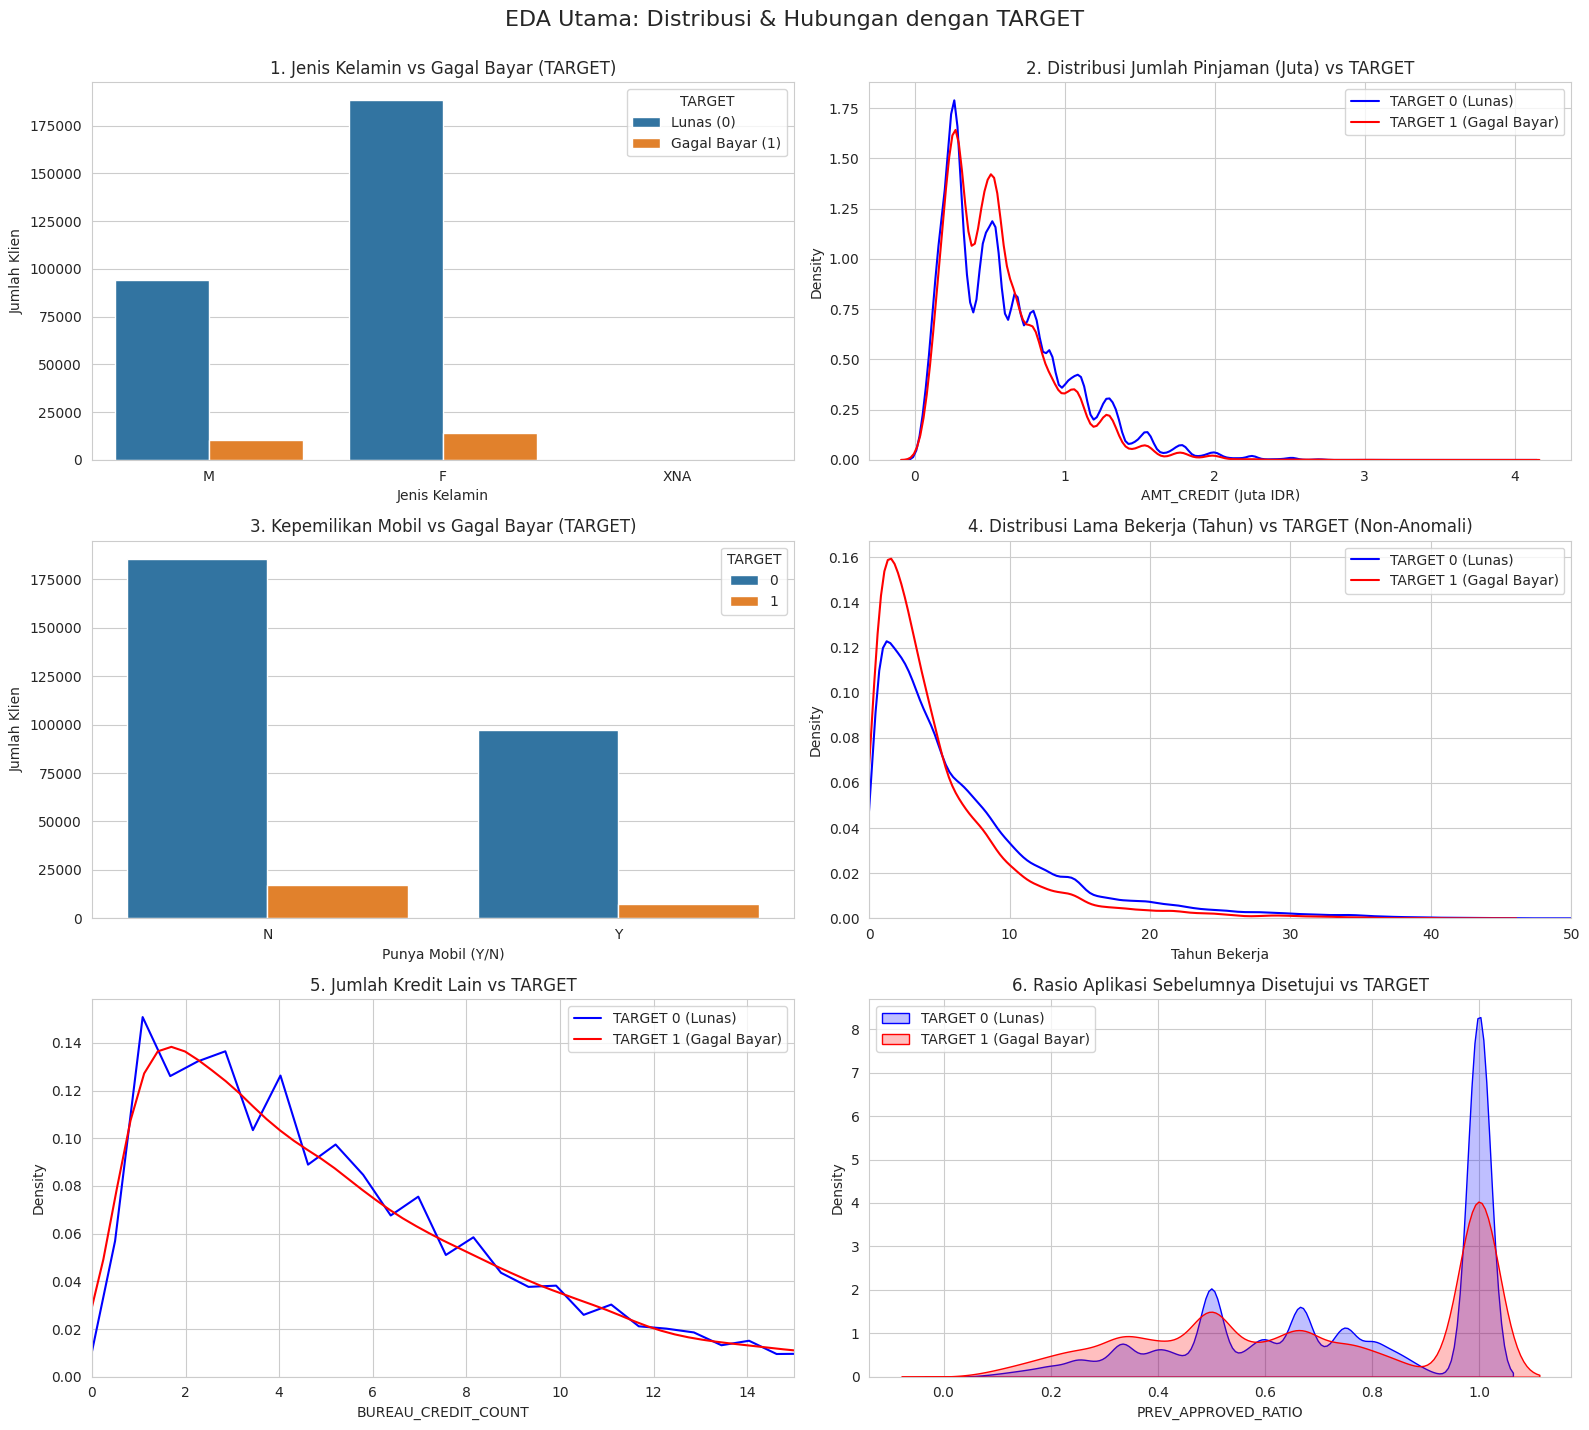

In [41]:
# --- 4. Fungsi Utama EDA dan Visualisasi ---
def run_eda_with_visuals():
    data = load_data()

    if 'train' not in data:
        print("\n[GAGAL] Data aplikasi utama (train) tidak ditemukan.")
        return

    df_train = data['train'].copy()

    # --- PROSES A: Feature Engineering & Join ---

    # 1. Join Biro Kredit
    if 'bureau' in data and 'bureau_balance' in data:
        bureau_features = aggregate_bureau(data['bureau'], data['bureau_balance'])
        df_train = pd.merge(df_train, bureau_features, on='SK_ID_CURR', how='left')
        print(f"✅ Fitur Bureau digabungkan. Dimensi baru: {df_train.shape}")

    # 2. Join Aplikasi Sebelumnya
    if 'previous' in data:
        prev_features = aggregate_previous(data['previous'])
        df_train = pd.merge(df_train, prev_features, on='SK_ID_CURR', how='left')
        print(f"✅ Fitur Previous Application digabungkan. Dimensi baru: {df_train.shape}")

    # Hapus data mentah yang besar
    del data; gc.collect()


    # --- PROSES B: Visualisasi Data Utama ---

    plt.figure(figsize=(16, 15))
    plt.suptitle("EDA Utama: Distribusi & Hubungan dengan TARGET", fontsize=16)

    # Visualisasi 1: Distribusi Jenis Kelamin vs TARGET
    plt.subplot(3, 2, 1)
    sns.countplot(x='CODE_GENDER', hue='TARGET', data=df_train)
    plt.title('1. Jenis Kelamin vs Gagal Bayar (TARGET)', fontsize=12)
    plt.xlabel('Jenis Kelamin')
    plt.ylabel('Jumlah Klien')
    plt.legend(title='TARGET', labels=['Lunas (0)', 'Gagal Bayar (1)'])

    # Visualisasi 2: AMT_CREDIT (Jumlah Pinjaman) vs TARGET (Density Plot)
    plt.subplot(3, 2, 2)
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'AMT_CREDIT'] / 1000000,
                label='TARGET 0 (Lunas)', color='blue')
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'AMT_CREDIT'] / 1000000,
                label='TARGET 1 (Gagal Bayar)', color='red')
    plt.title('2. Distribusi Jumlah Pinjaman (Juta) vs TARGET', fontsize=12)
    plt.xlabel('AMT_CREDIT (Juta IDR)')
    plt.legend()

    # Visualisasi 3: Status Kepemilikan Mobil vs TARGET
    plt.subplot(3, 2, 3)
    sns.countplot(x='FLAG_OWN_CAR', hue='TARGET', data=df_train)
    plt.title('3. Kepemilikan Mobil vs Gagal Bayar (TARGET)', fontsize=12)
    plt.xlabel('Punya Mobil (Y/N)')
    plt.ylabel('Jumlah Klien')

    # Visualisasi 4: DAYS_EMPLOYED (Hari Bekerja) - Penanganan Anomali
    plt.subplot(3, 2, 4)
    # Ganti nilai anomali 365243 (Tidak Diketahui/Anonim) dengan NaN
    df_temp = df_train.copy()
    df_temp['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
    df_temp['YEARS_EMPLOYED'] = -df_temp['DAYS_EMPLOYED'] / 365

    sns.kdeplot(df_temp.loc[df_temp['TARGET'] == 0, 'YEARS_EMPLOYED'],
                label='TARGET 0 (Lunas)', color='blue')
    sns.kdeplot(df_temp.loc[df_temp['TARGET'] == 1, 'YEARS_EMPLOYED'],
                label='TARGET 1 (Gagal Bayar)', color='red')
    plt.title('4. Distribusi Lama Bekerja (Tahun) vs TARGET (Non-Anomali)', fontsize=12)
    plt.xlabel('Tahun Bekerja')
    plt.xlim(0, 50) # Batasi visualisasi untuk rentang yang realistis
    plt.legend()

    # Visualisasi 5: Korelasi Fitur Bureau (Hasil Join)
    plt.subplot(3, 2, 5)
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'BUREAU_CREDIT_COUNT'],
                label='TARGET 0 (Lunas)', color='blue')
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'BUREAU_CREDIT_COUNT'],
                label='TARGET 1 (Gagal Bayar)', color='red')
    plt.title('5. Jumlah Kredit Lain vs TARGET', fontsize=12)
    plt.xlabel('BUREAU_CREDIT_COUNT')
    plt.xlim(0, 15)
    plt.legend()

    # Visualisasi 6: Korelasi Fitur Previous Application (Hasil Join)
    plt.subplot(3, 2, 6)
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'PREV_APPROVED_RATIO'],
                label='TARGET 0 (Lunas)', color='blue', shade=True)
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'PREV_APPROVED_RATIO'],
                label='TARGET 1 (Gagal Bayar)', color='red', shade=True)
    plt.title('6. Rasio Aplikasi Sebelumnya Disetujui vs TARGET', fontsize=12)
    plt.xlabel('PREV_APPROVED_RATIO')
    plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

# --- Eksekusi Script Utama ---
if __name__ == "__main__":
    try:
        run_eda_with_visuals()
    except Exception as e:
        print(f"\n[ERROR FATAL]: Terjadi kesalahan saat menjalankan EDA. Pastikan semua file CSV ada dan library terinstall. Detail error: {e}")